# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
#Installing the required package and importing the required libraries
#!pip install pycrf
#!pip install sklearn-crfsuite
#! pip install WordCloud
import pandas as pd
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn_crfsuite import metrics
model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

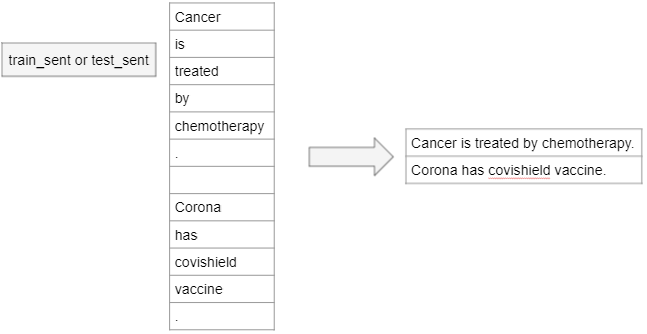

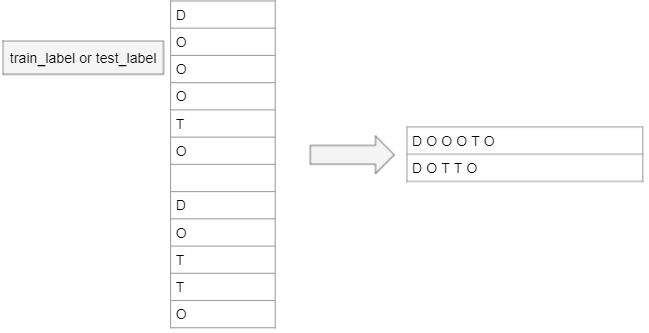

In [2]:
#defining a function to combine the words into sentences using the blank line as delimiter
def Data_processing(filepath):
    with open(filepath) as myFile:
        text = myFile.read()
        result = text.split("\n\n")
        Sentence=[sent.replace("\n", " ") for sent in result]
    return Sentence         
            

In [3]:
#processing the datasets to create the sentences.
train_sentences=Data_processing("train_sent")
train_labels=Data_processing("train_label")
test_sentences=Data_processing("test_sent")
test_labels=Data_processing("test_label")

Printing first five sentences and labels from the datasets

In [4]:
#printing the sentences
#printing the first five sebtences and respective labels from test dataset
print("\n\n---Printing Sentences and Labels from the Train set---\n")
for i in range (0,5):
    print(train_sentences[i])
    print(train_labels[i])
#printing the first five sebtences and respective labels from test dataset
print("\n\n---Printing Sentences and Labels from the Test set---\n")
for i in range (0,5):
    print(test_sentences[i])
    print(test_labels[i])



---Printing Sentences and Labels from the Train set---

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
O O O O O O O O O O O O O O O O O O O O O O O O O
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
O O O O O O O O O O O O O O O
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6

### Count the number of sentences in the processed train and test dataset 

In [5]:
#printing the length of the train_sentences and test_sentences to find the total number of sentences
print(len(train_sentences))
print(len(test_sentences))

2600
1057


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
#printing the length of the train_labels and test_labels to find the total number of sentences
print(len(train_labels))
print(len(test_labels))

2600
1057


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [7]:
#using spacy to extract the Noun and proper noun and their frequeny count
nlp=spacy.load("en_core_web_sm")
data_set_full=train_sentences+test_sentences
print(len(data_set_full))

Pos=[]
for sent in data_set_full:
    sent=sent.lower()
    processed_doc=nlp(sent)
    for tok in processed_doc:
        if (tok.pos_=='NOUN' or tok.pos_=='PROPN'):
            Pos.append(tok.text)

freq_dist = Counter(Pos)      

3657


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [8]:
#Printing the 25 most common tokens with NOUN or PROPN Pos tags
print(freq_dist.most_common(25))

[('patients', 507), ('treatment', 304), ('%', 246), ('cancer', 211), ('therapy', 177), ('study', 172), ('disease', 149), ('cell', 142), ('lung', 118), ('results', 116), ('group', 111), ('effects', 99), ('gene', 92), ('chemotherapy', 91), ('use', 88), ('effect', 82), ('women', 81), ('analysis', 76), ('to_see', 75), ('risk', 74), ('surgery', 73), ('cases', 72), ('p', 72), ('rate', 68), ('survival', 67)]


### EDA for most frequent Nouns or ProperNouns

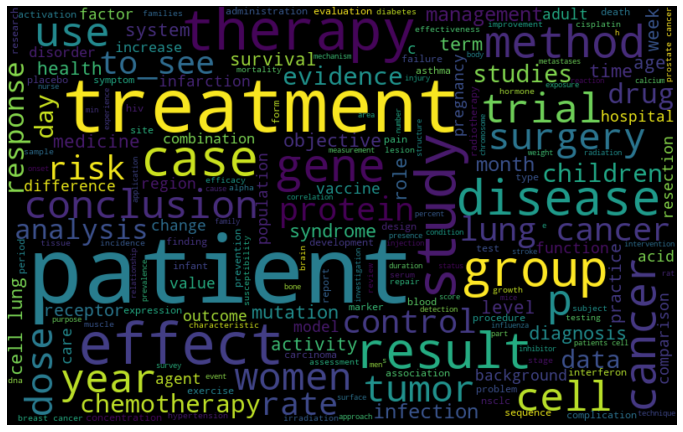

In [9]:
#displaying the most common Pos Tags using wordcloud
all_words = ' '.join([text for text in Pos])
wordcloud = WordCloud(width=800, height=500, random_state=21,
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Defining features for CRF





We have defined the following features for CRF model building:

- f1 = input word is in lower case; 
- f2 = pos tag of the word;
- f3 = last 3 characters of word;
- f4 = last 2 characers of word;
- f5 = 1; if the word is in uppercase, 0 otherwise;
- f6 = 1; if word is a number; otherwise, 0 
- f7= 1; if the word starts with a capital letter; otherwise, 0

Also for the same features for the previous words except for f3 and f4.The features if the word is at the begining('BEG') or at the end ('END') is also defined.


In [10]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence,pos,tokens):
    word=sentence[pos]
    word_pos_tag = tokens[pos].pos_
    features=['word.lower='+word.lower(),
              'word_POS_tag ='+ word_pos_tag,
              'word[-3:]='+word[-3:],
              'word[-2:]='+word[-2:],
              'word.isupper=%s' %word.isupper(),
              'word.isDigit=%s'%word.isdigit(),
              'word.StartsWithUpper=%s'%word[0].isupper()
             ]
    
    
    if (pos>0):
        prev_word=sentence[pos-1]
        prev_word_pos_tag = tokens[pos-1].pos_
        features.extend(['pre_-word.lower='+prev_word.lower(),
                         'prev_word_POS_tag = ' + prev_word_pos_tag,
                         'prev_word.isupper=%s' %prev_word.isupper(),
                         'prev_word.isDigit=%s'%prev_word.isdigit(),
                         'prev_word.StartsWithUpper=%s'%prev_word[0].isupper()
                        ])
    else:
        features.append('BEG')
    
    if (pos==len(sentence)-1):
        features.append('END')
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [11]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    sentence_list=sentence.split()
    tokens=nlp(sentence)
    return[getFeaturesForOneWord(sentence_list,pos,tokens) for pos in range (len(sentence_list))]


### Write a code/function to get the labels of a sentence

In [12]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [13]:
#defining the X_train and X_test inputs with feature values
X_train=[getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test=[getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [14]:
#defining the labels as the traget varriables
y_train=[getLabelsInListForOneSentence(labels) for labels in train_labels]
y_test=[getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [15]:
#!pip install -U scikit-learn==0.23

In [16]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train,y_train)

C:\Users\atsre\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(keep_tempfiles=None, max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [17]:
#Predicting the labels using the model created
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [18]:
#Calculating the f1 score for the model
metrics.flat_f1_score(y_test, Y_pred, average='weighted')

0.9065233371058995

<b>Observation:</b>The model shows and f1 score of <b>90.6%</b> which is very good for the model created.

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

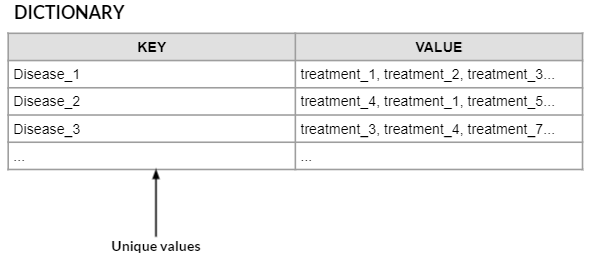

In [19]:
#Printing random test sentence and the predicted label 
print(test_sentences[20])
print(Y_pred[20])
print(test_labels[20])

Sequelae include severe developmental delay and asymmetric double hemiplegia
['O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D']
O O O O O O O O D


In [20]:
#defining a fuction to get the get the disease(Tag "D")and treatments(Tag "T") definied in the sentence
def get_disease_treatments(pos) :
  label_seq = Y_pred[pos]
  disease_indices= []
  treatment_indices = []
  for idx, label in enumerate(label_seq) :
    if label == "D" :
      disease_indices.append(idx)

    if label == "T" :
      treatment_indices.append(idx)
  
  return disease_indices, treatment_indices

In [21]:
#Creating a dictionary for Diseases as Key and Treatments as values
diseases = []
treatments = []
records = pd.DataFrame(columns = ["Disease", "Treatment"])
for id, sent in enumerate(test_sentences) :
  sent = sent.split()
  disease_idx, treatments_idx = get_disease_treatments(id)
  if len(disease_idx) > 0 and len(treatments_idx) > 0 :
    diseases.append(" ".join([sent[idx] for id, idx in enumerate(disease_idx) if id == 0 or idx == disease_idx[id-1] + 1]))
    treatments.append(" ".join([sent[idx] for idx in treatments_idx]))
records["Disease"] = diseases
records["Treatment"] = treatments
records["Treatment"] = records["Treatment"].apply(lambda x : x.replace("and", ",").replace(", ,", ","))
records = records.groupby("Disease")["Treatment"].apply(", ".join).reset_index()
Medical_dict=dict(records.values)
Medical_dict

{') zary syndrome': 'Extracorporeal photopheresis',
 'B16 melanoma': 'adenosine triphosphate , treatment with buthionine sulfoximine',
 "Eisenmenger 's syndrome": 'laparoscopic cholecystectomy',
 "Parkinson 's disease": 'Microelectrode-guided posteroventral pallidotomy',
 'abdominal tuberculosis': 'steroids',
 'acoustic neuroma': 'Stereotactic radiosurgery',
 'acute cerebral ischemia': 'Antiplatelet therapy',
 'acute myocardial infarction': 'Thrombolytic therapy, thrombolytic treatment',
 'acute nasopharyngitis ( ANP )': 'antibiotic treatment',
 'acute occlusion of the middle cerebral artery embolus or high-grade stenosis': 'thrombolytic therapy',
 'advanced esophageal cancer': 'adjuvant chemoradiotherapy with CDDP',
 'advanced non -- small-cell lung cancer': 'paclitaxel plus carboplatin ( pc ) vinorelbine plus cisplatin ( vc )',
 'advanced nsclc': 'assessing combination chemotherapy of cisplatin , ifosfamide , irinotecan with rhg-csf support',
 'advanced rectal cancer': 'Nerve-sparing

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [22]:
#getting the treatments defined in the dictionary for the disease 'hereditary retinoblastoma'
Treatment=Medical_dict.get("hereditary retinoblastoma")
Treatment

'radiotherapy'

<b>Conclusion:</b> The DRF model was build on the corpus with disease and treatements and created a dictionary of the diseases as keys and treatments as values using the model created.From this dictioary we can get the treatments by quering the disease name.The disctionary is not exhaustive as the model was build on and small corpus and could not possibly contain all the diseases and treatments.The model can be made better by training on a large corpous and also including many more features.

---End of Notebook---